# Homework 2: Programming

The following notebook contains skeleton-code for answering problems 2-4 of homework assignment 2. Please read through each cell carefully to understand what is expected to be implemented. For your final submission, please try to clean up any intermediate outputs used for debugging.


For sumbission, you need to submit
 - this notebook (.ipynb file) with all cell outputs
 - an exported PDF version with cell outputs of this notebook

You need to check that cell outputs are included in your PDF file \(sometimes the outputs will not be properly shown when exporting\), and then put them in the same ZIP file and submit to Homework 2-programming on Gradescope.



### Imports

You should be able to complete the entire assignment using only the following imports. Please consult the course staff if you are unsure about whether additional packages may be used.

In [1]:
## Import Packages
import random
import numpy as np
import matplotlib.pyplot as plt
import collections

## Question 2


Below we provide an AutoGrad class named `Value`. The basic idea is to store the existing computational map during the creation of each `Value`, and calculate the gradient using backpropagation when one of the `Value` calls `backward()` method.

The `backward()` function will arange the computational graph and backpropagate the gradients. All you need to do is to implement all the operations with its corresponding `_backward` function. We have provided the `__add__` function (sum of two nodes) as an example to help get you started.

This notebook is designed in a Object Oriented way, if you are not farmiliar with the Object Oriented Programming in Python, you can refer to:

(1) https://realpython.com/python3-object-oriented-programming/

(2) https://docs.python.org/3/tutorial/classes.html


In [2]:
class Value:

    """
    Basic unit of storing a single scalar value and its gradient
    """

    def __init__(self, data, _children=()):
        """

        """
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._backward = lambda: None

    def __add__(self, other):
        """
        Example implementation of a single class operation (addition)

        Args:
            other (Any): Node to add with the class

        Returns:
            out (callable): Function to referesh the gradient
        """
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)

        #Secondly, create a new Value object which is the result of the operation
        out = Value(self.data + other.data, (self, other))

        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplication operation (e.g. Value(3) * Value(2) = Value(6))
        """
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)
        
        #Secondly, create a new Value object which is the result of the operation
        out = Value(self.data * other.data, (self, other))
        
        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
            
        return out

    def __pow__(self, other):
        """
        Power operation (e.g Value(3) ** 2 = Value(9))
        """
        assert isinstance(other, (int, float))

        #Secondly, create a new Value object which is the result of the operation
        out = Value(self.data ** other, [self])
        
        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            multiplier = other * (self.data ** (other - 1))
            self.grad += out.grad * multiplier
        out._backward = _backward
        
        return out

    def __gt__(self, other):
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)

        return self.data > other.data
        

    def relu(self):
        """
        ReLU activation function applied to the current Value
        """        
        #Secondly, create a new Value object which is the result of the operation
        out = Value(max(0, self.data), [self])
        
        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad * (self.data > 0)
        out._backward = _backward

        return out


    def exp(self):
        """
        Exponentiate the current Value (e.g. e ^ Value(0) = Value(1))
        """        
        #Secondly, create a new Value object which is the result of the operation
        out = Value(np.exp(self.data), [self])
        
        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward

        return out

    def log(self):
        """
        Take the natural logarithm (base e) of the current Value
        """
        #The bottom number should be e, you can use numpy to calculate the value of the logarithm.
        #Secondly, create a new Value object which is the result of the operation
        out = Value(np.log(self.data), [self])
        
        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad * (1/self.data)
        out._backward = _backward

        return out
            

    def backward(self):
        """
        Run backpropagation from the current Value
        """
        #This function is called when you start backpropagation from this Value

        #The gradient of this value is initialized to 1 for you.
        self.grad = 1

        #You need to find a right topological order all of the children in the graph.
        #As for topology sort, you can refer to http://www.cs.cornell.edu/courses/cs312/2004fa/lectures/lecture15.htm
        
        q = collections.deque([self])
        indeg = collections.defaultdict(int)
        
        while len(q) > 0:
            curr = q.popleft()
            for child in curr._prev:
                indeg[child] += 1
                if indeg[child] == 1:
                    q.append(child)
                    
        topo = [self]
        q.append(self)
        while len(q) > 0:
            curr = q.popleft()
            for child in curr._prev:
                indeg[child] -= 1
                if indeg[child] == 0:
                    q.append(child)
                    topo.append(child)
                    
        #go one variable at a time and apply the chain rule to get its gradient

        for v in topo:
            v._backward()
            # print(v)

    # We handled the negation and reverse operations for you
    def __neg__(self): # -self
        """
        Negate the current Value
        """
        return self * -1

    def __radd__(self, other): #other + self
        """
        Reverse addition operation (ordering matters in Python)
        """
        return self + other

    def __sub__(self, other): # self - other
        """
        Subtraction operation
        """
        return self + (-other)

    def __rsub__(self, other): # other - self
        """
        Reverse subtraction operation
        """
        return other + (-self)

    def __rmul__(self, other): # other * self
        """
        Reverse multiplication operation
        """
        return self * other

    def __truediv__(self, other): # self / other
        """
        Division operation
        """
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        """
        Reverse diction operation
        """
        return other * self**-1

    def __repr__(self):
        """
        Class representation (instead of unfriendly memory address)
        """
        return f"Value(data={self.data}, grad={self.grad})"

Now, we are going to use the simple example in q1.b to get you familar with the usage of this class.

If your implementation is correct, you will get the same values and gradients as your hand-caculated ones.

Be careful! Even you get this test case right, it does not guarantee the correctness of your implementation.

In [3]:
## Initialize Example Values (From Written Assignment)
w1 = Value(0.2)
w2 = Value(0.4)
x1 = Value(-0.4)
x2 = Value(0.5)
print("Initial input nodes:", w1, w2, x1, x2)

#Do calculation for the question 1.b, and call backward to start backpropagation.
#Then print out the gradient of w1 w2 x1 x2.
n1 = w1 * x1
n2 = w2 * x2
n1 = n1 + n2
n1 *= -1
n1 = n1.exp()
n1 += 1
n1 = 1/n1

nn1 = w1 ** 2
nn2 = w2 ** 2
nn1 += nn2
nn1 /= 2

final = n1 + nn1
final.backward()
print("Input nodes:", w1, w2, x1, x2)

Initial input nodes: Value(data=0.2, grad=0) Value(data=0.4, grad=0) Value(data=-0.4, grad=0) Value(data=0.5, grad=0)
Input nodes: Value(data=0.2, grad=0.10035913775925998) Value(data=0.4, grad=0.524551077800925) Value(data=-0.4, grad=0.04982043112037002) Value(data=0.5, grad=0.09964086224074004)


## Question 3

### Implementation of the linear layer
You will implement a `LinearLayer` module here.

We provide the initialization of the class `LinearLayer`. You need to implement the forward function -- Return the results - `out` with the shape `[n_samples, n_out_channels]` of a linear layer when the the data `x` shaped `[n_samples, n_in_channels]` is fed into it.


In [4]:
class Module:

    """
    Base Model Module
    """

    def parameters(self):
        """

        """
        return []

    def zero_grad(self):
        """

        """
        for p in self.parameters():
            p.grad = 0

class LinearLayer(Module):

    """
    Linear Layer
    """

    def __init__(self, nin, nout):
        """
        Here we randomly initilize the weights w as 2-dimensional list of Values
        And b as 1-dimensional list of Values with value 0

        You may use this stucture to implement the __call__ function

        nin - number of inputs
        nout - number of outputs
        """
        self.w = [] # nout x nin matrix
        for i in range(nin):
            w_tmp = [Value(random.uniform(-1,1)) for j in range(nout)]
            self.w.append(w_tmp)

        self.b = [Value(0) for i in range(nout)]
        self.nin = nin
        self.nout = nout

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """

        batch_size = len(x)
        xout = [[0 for x in range(self.nout)] for x in range(batch_size)]
        for batch in range(batch_size):
            for i in range(self.nout):
                for j in range(self.nin):
                    xout[batch][i] += self.w[j][i] * x[batch][j]
                xout[batch][i] += self.b[i]

        return xout

    def parameters(self):
        """
        Get the list of parameters in the Linear Layer

        Args:
            None

        Returns:
            params (list): List of parameters in the layer
        """
        return [p for row in self.w for p in row] + [p for p in self.b]

Test your implementation of linear layer, the error should be nearly 0.

In [5]:
## Initialization of Layer with Weights
linear_model_test = LinearLayer(4, 4)
linear_model_test.w = [[Value(data=0.7433570245252463), Value(data=-0.9662164096144394), Value(data=-0.17087204941322653), Value(data=-0.5186656374983067)],
                       [Value(data=-0.1414882837892344), Value(data=-0.5898971049017006), Value(data=-0.3448340220492381), Value(data=0.5278833226346107)],
                       [Value(data=0.3990701306597799), Value(data=-0.3319058654296163), Value(data=-0.784797384411202), Value(data=0.7603317495966846)],
                       [Value(data=-0.5711035064293541), Value(data=-0.0001937643033362857), Value(data=0.12693226232877053), Value(data=-0.36044237239197097)]]
linear_model_test.b = [Value(data=0), Value(data=0), Value(data=0), Value(data=0)]

## Forward Pass
x_test = [[-0.17120438454836173, -0.3736077734087335, -0.48495413054653214, 0.8269206715993096]]
y_hat_test = linear_model_test(x_test)
y_ref = [[Value(data=-0.7401928625441141), Value(data=0.5466095223360173), Value(data=0.6436403600545564), Value(data=-0.7752067527386406)]]

## Error Calculation
predict_error = 0
for i in range(4):
    predict_error += (y_hat_test[0][i] - y_ref[0][i])**2
print("predicted error:", predict_error.data)

predicted error: 0.0


## Implementation of Loss functions

You will implement softmax, cross entropy loss, and accuracy here for further use

In [6]:
def softmax(y_hat):
    """
    Softmax computation

    Args:
        y_hat (2d-list): 2-dimensional list of Values with shape [batch_size, n_class]

    Returns:
        s (2d-list): 2-dimensional list of Values with the same shape as y_hat
    """
    
    batch_size = len(y_hat)
    assert batch_size > 0, "batch size should be greater than zero"
    n_class = len(y_hat[0])
    s = [[y.exp() for y in y_hat[i]] for i in range(batch_size)] # a way to implement without numpy in case you want to use this as an activation function layer and keep the Value diagram
    # s = np.exp(y_hat) # a way to implement exponentiation with numpy
    for batch in range(batch_size):
        sum = np.sum(s[batch])
        for i in range(n_class):
            s[batch][i] /= sum

    # s = -1 * np.log(s)
    return s

In [7]:
def cross_entropy_loss(y_hat, y):
    """
    Cross-entropy Loss computation

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ], where each entry 
        is the index of the true class label for the corresponding sample in the batch.

    Returns:
        loss (Value): Loss value of type Value
    """

    batch_size = len(y)
    assert batch_size > 0, "batch size should be greater than zero"
    n_class = len(y_hat[0])
    
    y_hat = softmax(y_hat)

    loss = Value(0)
    for i in range(batch_size):
        for j in range(n_class):
            loss -= y_hat[i][j].log() * (y[i] == j)
#         loss -=  y_hat[i][y[i]].log() # way to implement loss update without numpy function and using Value
#         loss -=  np.log(y_hat[i][y[i]])

    loss /= batch_size
    return loss

In [8]:
def accuracy(y_hat, y):
    """
    Accuracy computation. Accuracy is defined as the ratio of correctly classified samples 
    to the total number of samples in the entire batch.

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ], where each entry 
        is the index of the true class label for the corresponding sample in the batch.

    Returns:
        acc (float): Accuracy score
    """
    batch_size = len(y)
    assert batch_size > 0, "batch size should be greater than zero"
    correct = 0

    for i in range(batch_size):
        if np.argmax(y_hat[i]) == y[i]:
            correct += 1
    
    return correct/batch_size

Test the implementation of `softmax()` and `cross_entropy_loss()` as well as the gradient calculation of `Value` class. The errors should be nearly 0.

In [9]:
## Ground Truth + Forward Pass
y_gt = [1]
y_hat_test = linear_model_test(x_test)

## Softmax Calculation
prob_test = softmax(y_hat_test)
prob_ref = [[0.10441739448437284, 0.37811510516540814, 0.4166428991676558, 0.10082460118256342]]
softmax_error = 0
for i in range(4):
    softmax_error += (prob_ref[0][i] - prob_test[0][i])**2
print(softmax_error.data)

## Cross Entropy Loss Calculation
loss_test = cross_entropy_loss(y_hat_test, y_gt)
loss_ref = Value(data=0.9725566186970217)
print((loss_test - loss_ref).data)

## Update Gradient Based on Loss
linear_model_test.zero_grad()
loss_test.backward()
w_gradient_ref = [[-0.017876715758840547, 0.10646942068007896, -0.07133109112844363, -0.01726161379279479],
                  [-0.0390111502584479, 0.23234103087567629, -0.1556610258645873, -0.03766885475264107],
                  [-0.05063764675610328, 0.30158564847453107, -0.2020526949142369, -0.04889530680419089],
                  [0.08634490197366762, -0.5142494748940867, 0.3445306259968013, 0.08337394692361787]]
b_gradient_ref = [0.10441739448437282, -0.6218848948345919, 0.4166428991676557, 0.1008246011825634]

## Compute Error
w_gradient_error = 0
b_gradient_error = 0
for i in range(4):
    b_gradient_error += (linear_model_test.b[i].grad - b_gradient_ref[i]) ** 2
    for j in range(4):
        w_gradient_error += (linear_model_test.w[i][j].grad - w_gradient_ref[i][j]) ** 2
print(w_gradient_error)
print(b_gradient_error)

0.0
0.0
0.0
0.0


Implement the following functions to visualize the ground truth and the decision boundary in the same figure.

In [10]:
def plot_points(X, Y, scale, n, data):
    """
    Plot points in the visualization image:

    Args:
        X (np.ndarray): 2D array containing the coordinates of data points (Ex:[[x1, y1], [x2, y2], ...]
        Y (np.ndarray): 1D array containing the labels of the points.(Ex: [1, 3, 1, 2, 2])
        scale (float): the scale for x and y coordinates. The output x-axis will range from -scale to +scale 
        n (int): The dimensionality of the output image in pixels (n x n).
        data (np.ndarray):  3D array representing the image data (n x n x 3).

    Output:
        data (np.ndarray): updated data array with the points plotted.
    """
    points_color = [[0., 0. , 255.], [255., 0., 0.], [0., 255., 0.],[0., 0. , 0.]]

    for i in range(X.shape[0]):
        x1 = int(((X[i, 0] + scale) * n)/(2 * scale))
        x2 = int(((X[i, 1] + scale) * n)/(2 * scale))
        for color in range(3):
            data[x1, x2, color] = points_color[int(Y[i])][color]
            
    return data

def plot_background(scale, n, model):
    """
    Color the background in the visualization image

    Args:
        scale (float): The scale for x and y coordinates.
        n (int): The dimensionality of the output image in pixels (n x n).
        model (object): The machine learning model used for predictions.

    Output:
        data (np.ndarray): The data array with the background colored based on model predictions (n x n x 3).

    """

    background_color = [[0., 191., 255.], [255., 110., 180.], [202., 255., 112.],[156., 156., 156.]]

    data = np.zeros((n,n,3), dtype='uint8')

    for i in range(n):
        x1 = -scale + 2 * scale / n * i
        for j in range(n):
            x2 = -scale + 2 * scale / n * j
            input = [[Value(x1),Value(x2)]]
            y = model(input)
            data[i, j] = background_color[np.argmax(y[0])]
    return data


def visualization(X, Y, model):
    """
    Decision boundary visualization

     Args:
        X (np.ndarray): 2D array containing the coordinates of data points (Ex:[[x1, y1], [x2, y2], ...]
        Y (np.ndarray): 1D array containing the labels of the points.(Ex: [1, 3, 1, 2, 2])
        model (object): The machine learning model used for predictions.
        
    """
    scale = 4.5  # the scale of X axis and Y axis. To say, x is from -scale to +scale
    n = 300      # seperate the image into n*n pixels

    data = plot_background (scale, n, model)
    data = plot_points (X, Y, scale, n, data)

    plt.imshow(data)
    plt.axis('off')
    plt.show()

if you implement the plot function correctly, you will get some image like:

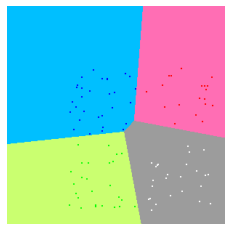


### Implementation of training procedure

With input data `x`, ground_truth `y`, and `model` as parameters, implement the gradient descent method to train your model and plot loss and accuracy vs training iterations

In [11]:
def train(x,
          y,
          model,
          loss_function=cross_entropy_loss,
          accuracy_function=accuracy,
          max_iteration=500,
          learning_rate=1):
    """
    Args:
       x (2-d list): List of Values with shape: [n_samples, n_channels]
       y (1-d list): List of integers with shape: [n_samples]
       model (Module): Linear model
       loss_function (callable): Loss function to use during training
       accuracy_function (callable): Function used for calculating training accuracy
       max_iteration (int): Number of epochs to train model for
       learning_rate (numeric): Step size of the gradient update
    """
    for i in range(max_iteration):
        y_hat = model(x) # [batch_size, nin]
        loss = loss_function(y_hat, y)
        acc = accuracy_function(y_hat, y)

        model.zero_grad()
        loss.backward()

        for p in model.parameters():
            p.data -= learning_rate * p.grad


        #Then plot the loss / accuracy vs iterations.
        if i % 20 == 19:
            print("iteration",i,"loss:",loss.data, "accuracy:",acc)
        ## record loss
        if i == 0 :
        # initialize L
            L = loss.data
            A = acc
        else:
            L = np.append(L,loss.data)
            A = np.append(A,acc)

    ## Plot Loss and Accuracy
    fig0=plt.figure(0)
    plt.plot(L,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    fig1=plt.figure(1)
    plt.plot(A,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.show()


### Train the model

Load the data, format it, instantiate your model and start training!

(100, 2) (100,) [0 1 2 3]
iteration 19 loss: 0.8859904055220024 accuracy: 0.86
iteration 39 loss: 0.6882455962555242 accuracy: 0.94
iteration 59 loss: 0.5853614062640079 accuracy: 0.95
iteration 79 loss: 0.5193145857606384 accuracy: 0.96
iteration 99 loss: 0.47213473399625167 accuracy: 0.96
iteration 119 loss: 0.4361714500630975 accuracy: 0.97
iteration 139 loss: 0.40753396311709866 accuracy: 0.97
iteration 159 loss: 0.38400197264376845 accuracy: 0.97
iteration 179 loss: 0.3642013487678806 accuracy: 0.97
iteration 199 loss: 0.34722870767425584 accuracy: 0.97
iteration 219 loss: 0.33246172504999766 accuracy: 0.98
iteration 239 loss: 0.31945541835183894 accuracy: 0.98
iteration 259 loss: 0.3078817895336081 accuracy: 0.98
iteration 279 loss: 0.2974928819378931 accuracy: 0.98
iteration 299 loss: 0.288097203753927 accuracy: 0.98
iteration 319 loss: 0.27954414351376594 accuracy: 0.98
iteration 339 loss: 0.27171335480998304 accuracy: 0.98
iteration 359 loss: 0.2645073360945111 accuracy: 0.98


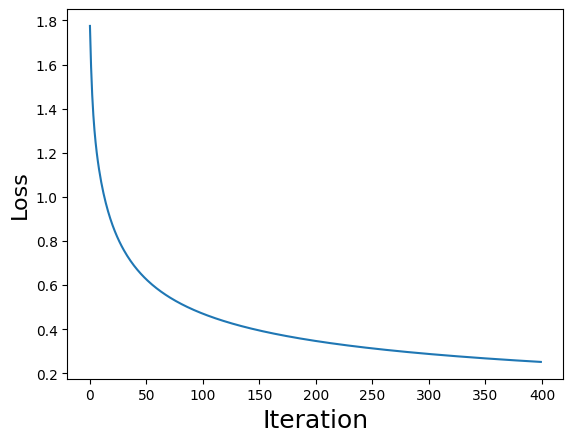

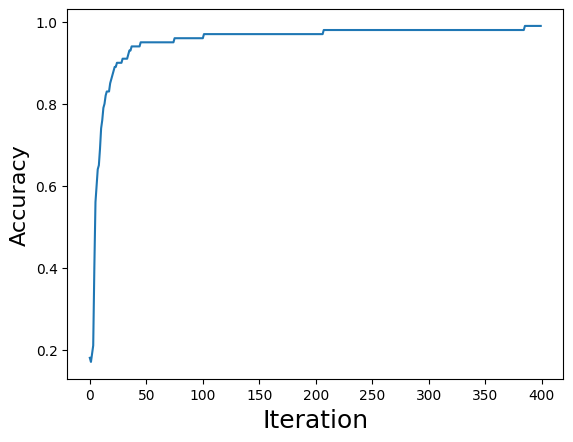

In [12]:
## Load Q3 Dataset
datapath = 'Q3_data.npz'
data = np.load(datapath)

## Load Data and Parse Shape Information
X = data['X']
Y = data['Y']
print(X.shape, Y.shape, np.unique(Y))
nin = X.shape[1]
nout = np.max(Y) + 1

## Initialize data using your Value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

## Initialize a Linear Model
linear_model = LinearLayer(nin, nout)

## Train the Model using Your Data
train(x, y, linear_model, max_iteration=400, learning_rate=0.3)

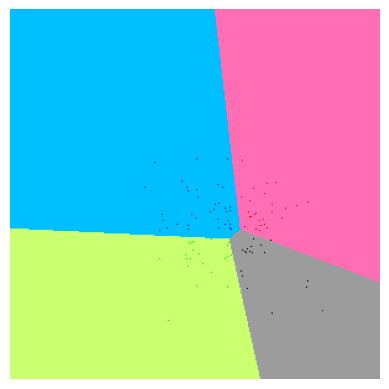

In [13]:
## Visualize learned decision boundaries
visualization(X, Y, linear_model)

## Question 4

### a) Is this dataset linear separable?
load the dataset for this question and train a linear model on this dataset and report the performance

In [14]:
## Load Q4 Dataset
datapath = 'Q4_data.npz'
data = np.load(datapath)

## Parse Data and Identify Dimensions
X = data['X']
Y = data['Y']
nin = X.shape[1]
nout = int(np.max(Y)) + 1

## Initialize data using your value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

iteration 19 loss: 0.7242967721468028 accuracy: 0.7
iteration 39 loss: 0.5183538051938239 accuracy: 0.825
iteration 59 loss: 0.45862817195029904 accuracy: 0.825
iteration 79 loss: 0.4293511563929969 accuracy: 0.825
iteration 99 loss: 0.41172850851112336 accuracy: 0.825
iteration 119 loss: 0.3999035750311499 accuracy: 0.825
iteration 139 loss: 0.39140250973720003 accuracy: 0.825
iteration 159 loss: 0.3849869592663644 accuracy: 0.825
iteration 179 loss: 0.37996541156531927 accuracy: 0.825
iteration 199 loss: 0.3759207728531964 accuracy: 0.825


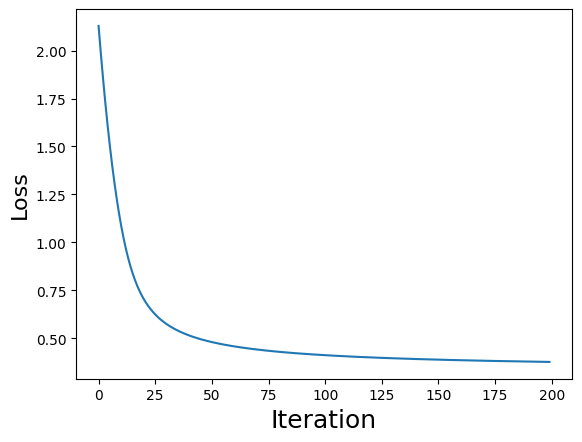

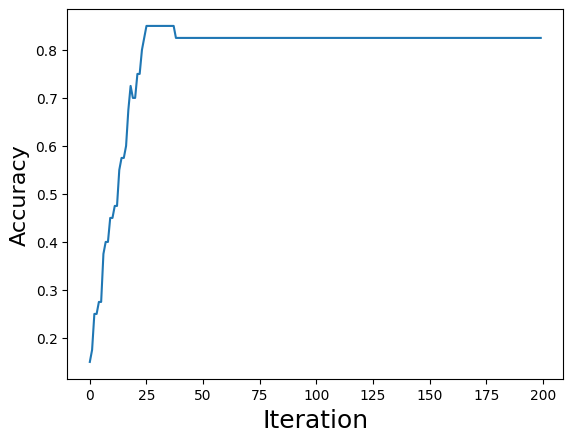

In [15]:
## Initialize Linear Model
linear_model = LinearLayer(nin, nout)

## Train Model
train(x, y, linear_model, max_iteration=200, learning_rate=0.1)

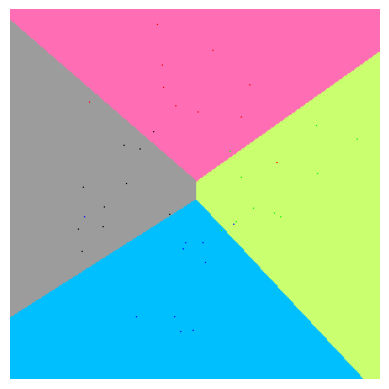

In [16]:
## Visualize Learned Decision Boundary
visualization(X, Y, linear_model)

### b) Implementation of Multi Layer Perceptron (MLP)

Implement a class `MLP` to add arbitrary layers. You will need to implement the forward function to return results `out` with `x` fed into the model.

In [17]:
class MLP(Module):

    """
    Multi Layer Perceptron
    """
    def __init__(self, dimensions):
        """
        Initialize multiple layers here in the list named self.linear_layers
        """
        assert isinstance(dimensions, list)
        assert len(dimensions) > 2
        self.linear_layers = []
        for i in range(len(dimensions) - 1):
            self.linear_layers.append(LinearLayer(dimensions[i], dimensions[i+1]))
            
    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        #TODO Implement this function and return the output of a MLP
        
        # Attach a ReLu activation function to each hidden layer except the last one being fed into the output xout
        for i in range(len(self.linear_layers) - 1):
            y = self.linear_layers[i](x) # y is the output of this current layer
            x = [[y_node.relu() for y_node in y[i]] for i in range(len(y))] # len(y) is batch size of previous layer | setting the output from previous layer through a ReLu as input as the next layer
        
        # Last hidden layer go directly to output
        xout = self.linear_layers[len(self.linear_layers) - 1](x)
        
        # Pass output through a softmax function
        xout = softmax(xout)
            
        return xout

    def parameters(self):
        """
        Get the parameters of each layer

        Args:
            None

        Returns:
            params (list of Values): Parameters of the MLP
        """
        return [p for layer in self.linear_layers for p in layer.parameters()]

    def zero_grad(self):
        """
        Zero out the gradient of each parameter
        """
        for p in self.parameters():
            p.grad = 0

Train your MLP model and visualize the decision boundary with ground truth points.

iteration 19 loss: 1.0609016409352543 accuracy: 0.7
iteration 39 loss: 1.0508861912371608 accuracy: 0.7
iteration 59 loss: 1.0466030521611713 accuracy: 0.7
iteration 79 loss: 1.0444978642017366 accuracy: 0.7
iteration 99 loss: 1.0432475842619147 accuracy: 0.7
iteration 119 loss: 1.0424117936914503 accuracy: 0.7
iteration 139 loss: 1.041799585674016 accuracy: 0.7
iteration 159 loss: 1.041329997297869 accuracy: 0.7
iteration 179 loss: 1.0409543412909625 accuracy: 0.7
iteration 199 loss: 1.0406497799713252 accuracy: 0.7
iteration 219 loss: 1.0403966991035472 accuracy: 0.7
iteration 239 loss: 1.0401815305879298 accuracy: 0.7
iteration 259 loss: 1.0399969775366154 accuracy: 0.7
iteration 279 loss: 1.0398365018189792 accuracy: 0.7
iteration 299 loss: 1.0396950532233944 accuracy: 0.7
iteration 319 loss: 1.039569409829547 accuracy: 0.7
iteration 339 loss: 1.0394569424702726 accuracy: 0.7
iteration 359 loss: 1.0393556679298672 accuracy: 0.7
iteration 379 loss: 1.0392636838419103 accuracy: 0.7
i

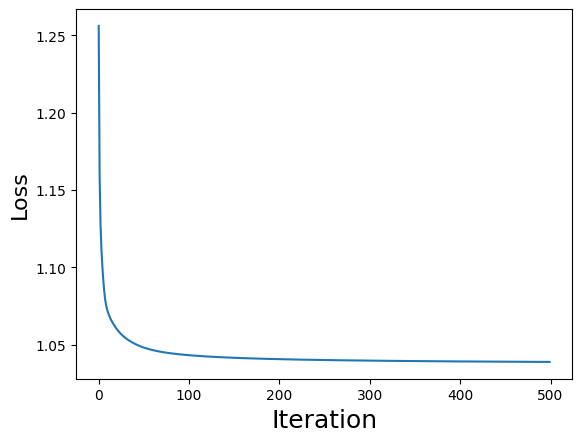

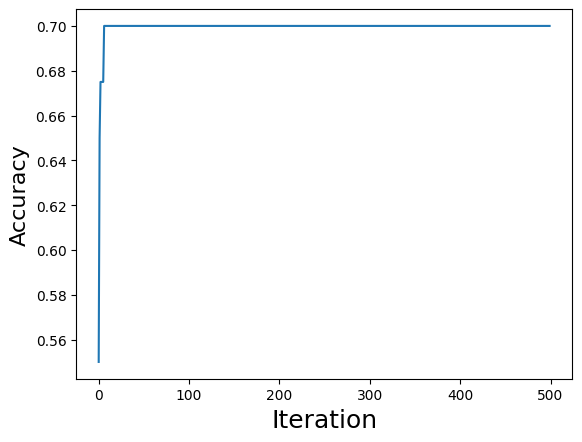

In [18]:
## Initialize MLP with Given Parameters
mlp_model = MLP([nin, 40, nout])

## Train the MLP
train(x, y, mlp_model, max_iteration=500, learning_rate=0.4)

In [ ]:
## Visualize Decision Boundaries
visualization(X, Y, mlp_model)

## Acknowledgement

The design of the auto grade structure are based on the work https://github.com/karpathy/micrograd